In [90]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [91]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(15.0),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [92]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [93]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


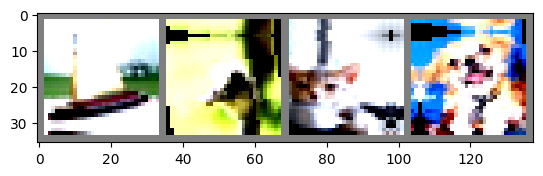

ship  bird  cat   dog  


In [94]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [95]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7), padding=3, bias=False),
            nn.BatchNorm2d(32), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 24, RF = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 22, RF = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, RF = 8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 11, RF = 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 9, RF = 12
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 7, RF = 16
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 11, RF = 8
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 7, RF = 20


        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
             nn.BatchNorm2d(32)
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 28
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 28

        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=1)) # output_size = 1, RF = 28

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = x + self.convblock3(x)
        # x = self.coonvblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = x + self.convblock6(x)
        # x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x + self.convblock9(x)
        # x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 180)
        return F.log_softmax(x, dim=-1)

In [96]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
       BatchNorm2d-2           [-1, 32, 32, 32]              64
           Dropout-3           [-1, 32, 32, 32]               0
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 16, 30, 30]           4,608
       BatchNorm2d-6           [-1, 16, 30, 30]              32
           Dropout-7           [-1, 16, 30, 30]               0
              ReLU-8           [-1, 16, 30, 30]               0
            Conv2d-9           [-1, 16, 30, 30]             256
      BatchNorm2d-10           [-1, 16, 30, 30]              32
          Dropout-11           [-1, 16, 30, 30]               0
             ReLU-12           [-1, 16, 30, 30]               0
        MaxPool2d-13           [-1, 16, 15, 15]               0
           Conv2d-14           [-1, 32,

The above model is less than 10k parameters

In [97]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Files already downloaded and verified


In [98]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [99]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 21


In [100]:
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


loss=2.1733734607696533 batch_id=390 Accuracy=18.96: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s]



Test set: Average loss: 2.3129, Accuracy: 2118/10000 (21.180%)

EPOCH: 1


loss=1.9211645126342773 batch_id=390 Accuracy=25.70: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]



Test set: Average loss: 2.1335, Accuracy: 2605/10000 (26.050%)

EPOCH: 2


loss=1.7938333749771118 batch_id=390 Accuracy=30.40: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s]



Test set: Average loss: 1.9865, Accuracy: 3057/10000 (30.570%)

EPOCH: 3


loss=1.8440310955047607 batch_id=390 Accuracy=33.68: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s]



Test set: Average loss: 2.0248, Accuracy: 2953/10000 (29.530%)

EPOCH: 4


loss=1.9622024297714233 batch_id=390 Accuracy=36.38: 100%|██████████| 391/391 [00:20<00:00, 18.91it/s]



Test set: Average loss: 1.9070, Accuracy: 3374/10000 (33.740%)

EPOCH: 5


loss=1.4792953729629517 batch_id=390 Accuracy=39.06: 100%|██████████| 391/391 [00:20<00:00, 19.19it/s]



Test set: Average loss: 1.8385, Accuracy: 3760/10000 (37.600%)

EPOCH: 6


loss=1.7305986881256104 batch_id=390 Accuracy=42.02: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s]



Test set: Average loss: 1.8026, Accuracy: 3939/10000 (39.390%)

EPOCH: 7


loss=1.5588809251785278 batch_id=390 Accuracy=44.71: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s]



Test set: Average loss: 1.6981, Accuracy: 4155/10000 (41.550%)

EPOCH: 8


loss=1.6888096332550049 batch_id=390 Accuracy=46.76: 100%|██████████| 391/391 [00:20<00:00, 18.86it/s]



Test set: Average loss: 1.6586, Accuracy: 4363/10000 (43.630%)

EPOCH: 9


loss=1.474963903427124 batch_id=390 Accuracy=47.89: 100%|██████████| 391/391 [00:21<00:00, 18.58it/s]



Test set: Average loss: 1.6945, Accuracy: 4418/10000 (44.180%)

EPOCH: 10


loss=1.5873711109161377 batch_id=390 Accuracy=48.94: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s]



Test set: Average loss: 1.6959, Accuracy: 4232/10000 (42.320%)

EPOCH: 11


loss=1.1859937906265259 batch_id=390 Accuracy=49.84: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s]



Test set: Average loss: 1.6379, Accuracy: 4451/10000 (44.510%)

EPOCH: 12


loss=1.617586374282837 batch_id=390 Accuracy=50.81: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]



Test set: Average loss: 1.5169, Accuracy: 4852/10000 (48.520%)

EPOCH: 13


loss=1.7052714824676514 batch_id=390 Accuracy=51.19: 100%|██████████| 391/391 [00:21<00:00, 18.50it/s]



Test set: Average loss: 1.5269, Accuracy: 4886/10000 (48.860%)

EPOCH: 14


loss=1.4330859184265137 batch_id=390 Accuracy=51.92: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s]



Test set: Average loss: 1.8164, Accuracy: 3882/10000 (38.820%)

EPOCH: 15


loss=1.5275784730911255 batch_id=390 Accuracy=52.38: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s]



Test set: Average loss: 1.5039, Accuracy: 4872/10000 (48.720%)

EPOCH: 16


loss=1.545619010925293 batch_id=390 Accuracy=53.17: 100%|██████████| 391/391 [00:20<00:00, 19.22it/s]



Test set: Average loss: 1.5351, Accuracy: 4708/10000 (47.080%)

EPOCH: 17


loss=1.2734946012496948 batch_id=390 Accuracy=53.25: 100%|██████████| 391/391 [00:20<00:00, 18.74it/s]



Test set: Average loss: 1.4281, Accuracy: 5125/10000 (51.250%)

EPOCH: 18


loss=1.541058897972107 batch_id=390 Accuracy=54.01: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s]



Test set: Average loss: 1.4455, Accuracy: 5096/10000 (50.960%)

EPOCH: 19


loss=1.2103341817855835 batch_id=390 Accuracy=54.07: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]



Test set: Average loss: 1.4128, Accuracy: 5178/10000 (51.780%)

EPOCH: 20


loss=1.3673452138900757 batch_id=390 Accuracy=54.61: 100%|██████████| 391/391 [00:22<00:00, 17.46it/s]



Test set: Average loss: 1.4819, Accuracy: 5023/10000 (50.230%)



In [107]:
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 10
conv_layers


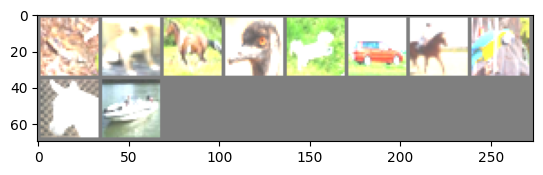

In [108]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

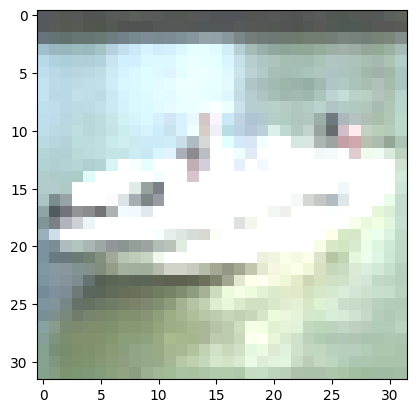

In [109]:
image = images[9]
imshow(image)

In [110]:
image = image.unsqueeze(0)
image = image.to(device)

In [111]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

10
torch.Size([1, 32, 32, 32])
torch.Size([1, 16, 30, 30])
torch.Size([1, 16, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 26, 26])
torch.Size([1, 32, 26, 26])
torch.Size([1, 32, 26, 26])
torch.Size([1, 32, 24, 24])
torch.Size([1, 32, 24, 24])
torch.Size([1, 20, 24, 24])


In [112]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(30, 30)
(30, 30)
(28, 28)
(26, 26)
(26, 26)
(26, 26)
(24, 24)
(24, 24)
(24, 24)


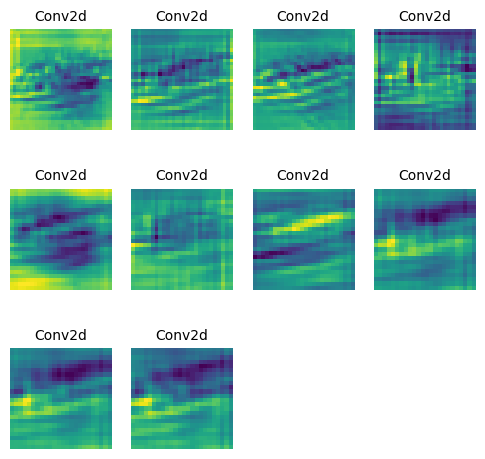

In [113]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

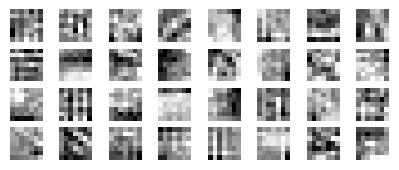

In [114]:
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()